# Automated detection of IDC in breast cancer whole slide image patches using Convoluted Neural Network

#  Introduction 

Over the past couple of years, there has been a rise in using deep learning for medical image analysis with increasing success. Deep learning in the field of healthcare is used to identify patterns, classify and segment medical images. As with most image related tasks, convolutional neural networks are used to do this.
The classification problem tackled here is to classify histopathology slides of Invasive Ductal Carcinoma (IDC) as either malignant or benign.

<img src= "https://miro.medium.com/max/770/1*dD7oWfCLnS8kHPZLqHo5yg.png">
<i>Histopathology slide of a malignant tumour. 
Image credits: Department of Pathology at Johns Hopkins University</i>

IDC is a type of breast cancer, where the cancer has spread to the surrounding breast tissue.

Cancer tumours can be classified into two types: malignant and benign. A benign tumor is one which does not invade its surrounding tissues whereas a malignant tumor is one which may spread to its surrounding tissues or other parts of the body.

## Understanding the dataset
The dataset I will use can be downloaded __[here]( http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip)__

The dataset consists of 162 whole mount slide images of breast cancer specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted, out of which 198,738 are IDC negative (benign) and 78,786 are IDC positive (malignant).

Each patch’s file name is of the format:

u_xX_yY_classC.png → example 10253_idx5_x1351_y1101_class0.png

Where 
- u is the patient ID (10253_idx5), 
- X is the x-coordinate of where this patch was cropped from, 
- Y is the y-coordinate of where this patch was cropped from, and
- C indicates the class where <b> 0 is non-IDC (benign)</b> and <b> 1 is IDC (malignant)</b>

In [2]:
from glob import glob
import fnmatch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf

sess = tf.Session() # to check which GPU tensorflow is using 

C:\Users\iwin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\iwin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\iwin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\iwin\AppData\Roaming\Python\Python37\site-pack

In [4]:
import keras

Using TensorFlow backend.


## Loading the Dataset
I will create two variable class_Zero and class_One and save the image locations of all class 0 and class 1 images in these variables respectively

In [5]:
image_Patches = glob('D:\DataAnalysisRyerson\CKME136_Capstone\Resources\Breast cancer\**\*.png', recursive=True)

In [6]:
pattern_Zero = '*class0.png'
pattern_One = '*class1.png'

#to save the file location of all images with file name class0
class_Zero = fnmatch.filter(image_Patches, pattern_Zero)

#to save the file location of all images with file name class1
class_One = fnmatch.filter(image_Patches, pattern_One) 

I create a function process_images that takes the starting and end index of the images. The function reads the image using OpenCV's cv2.imread() and resizes the images 

In [7]:
def process_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of corresponding labels
    """ 
#Resizing all the images to a standard format of dimensions 50X50X3    
    height = 50
    width = 50
    channels = 3
    
    x = [] # a list to store image data
    y = [] # a list to store corresponding class
    for img in image_Patches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        image = (cv2.resize(full_size_image, (width,height), interpolation=cv2.INTER_CUBIC))
        x.append(image)
        if img in class_Zero:
            y.append(0)
        elif img in class_One:
            y.append(1)
        else:
            return
    return x,y

---

I will analyze the images from index 0 to 60000 in the beginning and keep tuning this hyperparameter to improve the accuracy of the model. This image data or pixel value is stored in the list X and its corresponding class is stored in list Y

In [8]:
X, Y = process_images(0,100000)

---

## Data Preprocessing
To save space, the list X is first converted to a numpy array and then casted to type float32 

In [9]:
X = np.array(X)

In [9]:
X

array([[[[206, 164, 226],
         [196, 154, 224],
         [211, 175, 225],
         ...,
         [237, 221, 240],
         [214, 184, 232],
         [235, 213, 243]],

        [[188, 142, 217],
         [179, 130, 221],
         [196, 150, 224],
         ...,
         [204, 170, 227],
         [215, 180, 229],
         [232, 212, 236]],

        [[212, 178, 237],
         [199, 157, 229],
         [175, 125, 218],
         ...,
         [217, 184, 221],
         [193, 153, 190],
         [208, 164, 227]],

        ...,

        [[192, 145, 217],
         [184, 129, 214],
         [183, 129, 212],
         ...,
         [185, 122, 194],
         [193, 143, 204],
         [188, 129, 189]],

        [[192, 144, 218],
         [185, 128, 213],
         [171, 121, 208],
         ...,
         [145,  79, 136],
         [174, 111, 184],
         [176, 112, 188]],

        [[181, 125, 212],
         [181, 136, 211],
         [206, 162, 220],
         ...,
         [152,  90, 127],
        

In [10]:
X = X.astype(np.float32) #Casting the array to single precision takes half as much space

In [11]:
X

array([[[[206., 164., 226.],
         [196., 154., 224.],
         [211., 175., 225.],
         ...,
         [237., 221., 240.],
         [214., 184., 232.],
         [235., 213., 243.]],

        [[188., 142., 217.],
         [179., 130., 221.],
         [196., 150., 224.],
         ...,
         [204., 170., 227.],
         [215., 180., 229.],
         [232., 212., 236.]],

        [[212., 178., 237.],
         [199., 157., 229.],
         [175., 125., 218.],
         ...,
         [217., 184., 221.],
         [193., 153., 190.],
         [208., 164., 227.]],

        ...,

        [[192., 145., 217.],
         [184., 129., 214.],
         [183., 129., 212.],
         ...,
         [185., 122., 194.],
         [193., 143., 204.],
         [188., 129., 189.]],

        [[192., 144., 218.],
         [185., 128., 213.],
         [171., 121., 208.],
         ...,
         [145.,  79., 136.],
         [174., 111., 184.],
         [176., 112., 188.]],

        [[181., 125., 212.],
       

The images are normalized by dividing it by 255. This ensures all the values are between 0 and 1. This will help to train the model faster and prevent the vanishing and the exploding gradient problem

In [11]:
X /= 255.

In [13]:
X

array([[[[0.80784315, 0.6431373 , 0.8862745 ],
         [0.76862746, 0.6039216 , 0.8784314 ],
         [0.827451  , 0.6862745 , 0.88235295],
         ...,
         [0.92941177, 0.8666667 , 0.9411765 ],
         [0.8392157 , 0.72156864, 0.9098039 ],
         [0.92156863, 0.8352941 , 0.9529412 ]],

        [[0.7372549 , 0.5568628 , 0.8509804 ],
         [0.7019608 , 0.50980395, 0.8666667 ],
         [0.76862746, 0.5882353 , 0.8784314 ],
         ...,
         [0.8       , 0.6666667 , 0.8901961 ],
         [0.84313726, 0.7058824 , 0.8980392 ],
         [0.9098039 , 0.83137256, 0.9254902 ]],

        [[0.83137256, 0.69803923, 0.92941177],
         [0.78039217, 0.6156863 , 0.8980392 ],
         [0.6862745 , 0.49019608, 0.85490197],
         ...,
         [0.8509804 , 0.72156864, 0.8666667 ],
         [0.75686276, 0.6       , 0.74509805],
         [0.8156863 , 0.6431373 , 0.8901961 ]],

        ...,

        [[0.7529412 , 0.5686275 , 0.8509804 ],
         [0.72156864, 0.5058824 , 0.8392157 ]

---

The resulting dataset is split into training and testing set, with 15 percent of the entire dataset reserved for testing

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.15)

In [15]:
X_train

array([[[[0.69803923, 0.5803922 , 0.7019608 ],
         [0.7294118 , 0.654902  , 0.8509804 ],
         [0.8862745 , 0.85882354, 0.9254902 ],
         ...,
         [0.7607843 , 0.67058825, 0.8666667 ],
         [0.7529412 , 0.6627451 , 0.8509804 ],
         [0.7137255 , 0.5764706 , 0.8039216 ]],

        [[0.8039216 , 0.74509805, 0.84313726],
         [0.84705883, 0.8       , 0.91764706],
         [0.9254902 , 0.9254902 , 0.9490196 ],
         ...,
         [0.7529412 , 0.65882355, 0.85882354],
         [0.74509805, 0.6431373 , 0.8666667 ],
         [0.7647059 , 0.67058825, 0.8392157 ]],

        [[0.8862745 , 0.8666667 , 0.9137255 ],
         [0.9254902 , 0.90588236, 0.9372549 ],
         [0.92941177, 0.91764706, 0.9372549 ],
         ...,
         [0.7529412 , 0.6431373 , 0.87058824],
         [0.74509805, 0.6509804 , 0.8666667 ],
         [0.73333335, 0.63529414, 0.8627451 ]],

        ...,

        [[0.8       , 0.70980394, 0.85882354],
         [0.8039216 , 0.7294118 , 0.89411765]

In [16]:
X_test

array([[[[0.68235296, 0.5764706 , 0.8627451 ],
         [0.6901961 , 0.5568628 , 0.79607844],
         [0.7254902 , 0.60784316, 0.80784315],
         ...,
         [0.49803922, 0.29411766, 0.43137255],
         [0.6431373 , 0.48235294, 0.6784314 ],
         [0.5647059 , 0.3882353 , 0.5529412 ]],

        [[0.72156864, 0.59607846, 0.8392157 ],
         [0.8       , 0.7254902 , 0.8745098 ],
         [0.7058824 , 0.5764706 , 0.81960785],
         ...,
         [0.61960787, 0.4509804 , 0.6431373 ],
         [0.6392157 , 0.47843137, 0.6039216 ],
         [0.6039216 , 0.4117647 , 0.5803922 ]],

        [[0.78431374, 0.6901961 , 0.79607844],
         [0.79607844, 0.69803923, 0.80784315],
         [0.7137255 , 0.5764706 , 0.8       ],
         ...,
         [0.6       , 0.43137255, 0.57254905],
         [0.6862745 , 0.52156866, 0.6784314 ],
         [0.5411765 , 0.34509805, 0.49411765]],

        ...,

        [[0.7490196 , 0.6392157 , 0.84313726],
         [0.7294118 , 0.62352943, 0.7921569 ]

In [17]:
y_train

[1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,


In [18]:
y_test

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


---

### Random undersampling to tackle data imbalance
I will count the number of cases of benign (class 0) and malignant (class 1) cases to check for data imbalance which will affect the model to be more biased towards one particular class, overall affecting the accuracy.

In [13]:
Y.count(0) #Checking the number of 0's in the array Y (this denotes number of malignant cases)

70901

In [14]:
Y.count(1) #Checking the number of 1's in the array Y (this denotes number of malignant cases)

29099

In [15]:
y_train.count(1) #Checking the number of 1's in the array y_train

24778

In [16]:
y_train.count(0) #Checking the number of 0's in the array y_train

60222

From the above results it can be observed that the number of benign cases outnumber the malignant ones. This can be solved by randomly undersampling the majority class and to make the number of samples in both classes equal

---

In [17]:
from keras.utils import to_categorical

Before random undersampling I will one-hot-encode the y_train and y_test, this is done to provide the machine learning algorithm, the categorical variable in a form, that will help it do a better job in prediction.

In [18]:
#One-Hot-Encode y_train and y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [26]:
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

---

### Reshaping X_train and X_test to use Random Under Sampler

In [19]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [28]:
print(X_trainShape)
print(X_testShape)
print(X_trainFlat)
print(X_testFlat)

7500
7500
[[0.69803923 0.5803922  0.7019608  ... 0.7254902  0.627451   0.8627451 ]
 [0.8392157  0.7882353  0.8901961  ... 0.9372549  0.92941177 0.93333334]
 [0.9490196  0.9372549  0.9529412  ... 0.78039217 0.63529414 0.827451  ]
 ...
 [0.78431374 0.6745098  0.8352941  ... 0.5921569  0.39215687 0.80784315]
 [0.7529412  0.6392157  0.85882354 ... 0.7294118  0.58431375 0.8509804 ]
 [0.6392157  0.47058824 0.70980394 ... 0.7137255  0.5686275  0.8156863 ]]
[[0.68235296 0.5764706  0.8627451  ... 0.77254903 0.6392157  0.827451  ]
 [0.95686275 0.9490196  0.95686275 ... 0.95686275 0.9529412  0.9607843 ]
 [0.9490196  0.9411765  0.9529412  ... 0.654902   0.47843137 0.7294118 ]
 ...
 [0.6313726  0.40784314 0.69411767 ... 0.5176471  0.27450982 0.41960785]
 [0.827451   0.7176471  0.8666667  ... 0.57254905 0.36862746 0.60784316]
 [0.92156863 0.8980392  0.9372549  ... 0.6039216  0.4745098  0.8392157 ]]


## Using Random Under Sampler
I am using sampling_strategy ='majority' as this will under sample the majority class

In [20]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampler = RandomUnderSampler(sampling_strategy='majority')
X_trainRus, Y_trainRus = random_under_sampler.fit_sample(X_trainFlat, y_train)
X_testRus, Y_testRus = random_under_sampler.fit_sample(X_testFlat, y_test)

D:\Anaconda\envs\IwinEnv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\envs\IwinEnv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\envs\IwinEnv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

In [30]:
print(X_trainRus)
print(Y_trainRus)
print(X_testRus)
print(Y_testRus)

[[0.8392157  0.76862746 0.9254902  ... 0.81960785 0.76862746 0.91764706]
 [0.9411765  0.9411765  0.9490196  ... 0.85490197 0.8        0.8509804 ]
 [0.8745098  0.83137256 0.95686275 ... 0.9647059  0.96862745 0.98039216]
 ...
 [0.58431375 0.3764706  0.84705883 ... 0.9411765  0.9372549  0.9411765 ]
 [0.9254902  0.91764706 0.95686275 ... 0.5647059  0.38431373 0.58431375]
 [0.6862745  0.54509807 0.85490197 ... 0.68235296 0.52156866 0.73333335]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[0.91764706 0.91764706 0.92156863 ... 0.84313726 0.8        0.8352941 ]
 [0.6313726  0.39215687 0.7882353  ... 0.78431374 0.6862745  0.8901961 ]
 [0.8235294  0.77254903 0.9137255  ... 0.9098039  0.8745098  0.9372549 ]
 ...
 [0.5294118  0.31764707 0.44705883 ... 0.62352943 0.40784314 0.5921569 ]
 [0.41568628 0.21960784 0.3882353  ... 0.78039217 0.65882355 0.7490196 ]
 [0.6313726  0.40784314 0.69411767 ... 0.5176471  0.27450982 0.41960785]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [21]:
# One-hot-encoding
Y_trainRusHot = to_categorical(Y_trainRus, num_classes = 2)
Y_testRusHot = to_categorical(Y_testRus, num_classes = 2)

In [32]:
print(Y_trainRusHot)
print(Y_testRusHot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


----

### Checking the number of samples in each class to make sure RandomUnderSampling worked

In [22]:
np.unique(Y_trainRus, return_counts=True) 

(array([0, 1]), array([24778, 24778], dtype=int64))

In [23]:
for i in range(len(X_trainRus)):
    height, width, channels = 50,50,3
    X_trainRusReshaped = X_trainRus.reshape(len(X_trainRus),\
                                            height,width,channels)

In [35]:
X_trainRusReshaped

array([[[[0.8392157 , 0.76862746, 0.9254902 ],
         [0.8392157 , 0.7647059 , 0.8862745 ],
         [0.84313726, 0.77254903, 0.88235295],
         ...,
         [0.7137255 , 0.5921569 , 0.8901961 ],
         [0.72156864, 0.6       , 0.89411765],
         [0.72156864, 0.58431375, 0.8784314 ]],

        [[0.79607844, 0.67058825, 0.8862745 ],
         [0.81960785, 0.7372549 , 0.8901961 ],
         [0.7607843 , 0.6509804 , 0.8745098 ],
         ...,
         [0.6627451 , 0.49803922, 0.87058824],
         [0.67058825, 0.47058824, 0.8627451 ],
         [0.63529414, 0.47058824, 0.85882354]],

        [[0.67058825, 0.5568628 , 0.6666667 ],
         [0.9137255 , 0.8862745 , 0.9411765 ],
         [0.94509804, 0.93333334, 0.9529412 ],
         ...,
         [0.69411767, 0.54901963, 0.8745098 ],
         [0.7176471 , 0.5803922 , 0.84705883],
         [0.6862745 , 0.5176471 , 0.8745098 ]],

        ...,

        [[0.5058824 , 0.3019608 , 0.56078434],
         [0.57254905, 0.4       , 0.6745098 ]

In [24]:
for i in range(len(X_testRus)):
    height, width, channels = 50,50,3
    X_testRusReshaped = X_testRus.reshape(len(X_testRus),\
                                          height,width,channels)

In [37]:
X_testRusReshaped

array([[[[0.91764706, 0.91764706, 0.92156863],
         [0.9254902 , 0.9137255 , 0.9254902 ],
         [0.92156863, 0.9019608 , 0.92941177],
         ...,
         [0.73333335, 0.5803922 , 0.78039217],
         [0.8980392 , 0.85490197, 0.8980392 ],
         [0.8352941 , 0.7647059 , 0.8509804 ]],

        [[0.9254902 , 0.9137255 , 0.92941177],
         [0.91764706, 0.9019608 , 0.92156863],
         [0.9254902 , 0.92941177, 0.92156863],
         ...,
         [0.80784315, 0.75686276, 0.85490197],
         [0.87058824, 0.8156863 , 0.88235295],
         [0.8235294 , 0.76862746, 0.8666667 ]],

        [[0.9137255 , 0.9137255 , 0.9254902 ],
         [0.9254902 , 0.9137255 , 0.92941177],
         [0.8862745 , 0.84313726, 0.87058824],
         ...,
         [0.6117647 , 0.4117647 , 0.7137255 ],
         [0.64705884, 0.49411765, 0.7490196 ],
         [0.7019608 , 0.5568628 , 0.7529412 ]],

        ...,

        [[0.87058824, 0.827451  , 0.8862745 ],
         [0.7058824 , 0.6039216 , 0.7490196 ]

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [26]:
batch_size = 256
num_classes = 2
epochs = 40

## CNN Architecture
I am using a sequential model which allows to create the model layer-by-layer. This architecture consists of convolutional layers, max pooling layers, dropout layers and fully connected layers.

The first layer is a convolutional layer with 32 filter each of size 3 x 3.
Also the input shape in the first layer is 50 x 50 x 3.
Rectified linear unit (ReLU) activation function is the most common choice for the activation function and has been demonstrated to the very effective. I am using the ReLU layer for all the layers except the final output layer.

The second layer is a pooling layer, which is used to reduce the dimension. Max Pooling with a 2x2 window only considers the maximum value in the 2x2 window

The third layer is a convolutional layer of 64 filters of the size 3x3 followed by another max pooling layer of 2x2 window.

The next two layers are convolutional layers wit he same filter size but with an increasing number of filters, 128 and 256 respectively.

A flatten layer will be added which flattens the 3-Dimension feature map output from the convolutional layer to 1-Dimensional feature vector. This will then be added to the fully connected layer.

The next layer is a dropout layer with a dropout rate of 0.5, which means that the 50% of the neurons in the neural network will be turned off randomly. This would help to prevent overfitting by making all the neurons learn about the data and not rely on only some neurons. Randomly turning off the neurons during training means other neurons will have to do the learning of the turned off neurons. This helps in generalizing and preventing overfitting.
These dropout layers are added after each fully connected layers before the output layer, this also reduced the training time for each epochs.

The next layer is another dense layer with 128 neurons.

The final layer is a dense layer with the number of neurons equal to number of classes. I am using a sigmoid activation function as it is a binary classification problem. If it was a multi-class classification, I would be using the softmax activation function.

In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
# converting the 3D feature maps to 1D feature vectors for the- 
# dense layer below
model.add(Flatten()) 
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

## Compiling the model
The model is compiled using the binary cross entropy loss function and using the adaptive moment estimation (Adam) optimizer.
Adam is an extension of the stochastic gradient descent, to update the network weights iterative based on the training data. It combines the advantages of both adaptive gradient algorithm and the root mean square propagation, it adapts the parameter learning rates based on the average first mean and also the average of the second means of the gradients.
I am using a learning rate of 0.00001. Too high a learning rate can result in high weight changes that might result in overshooting the local minima and causes the training or validation error to fluctuate between the consecutive epochs. Similarly, too low a learning rate can result in increased network training times.

In [28]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


----

## Data Augmentation
Keras ImageDataGenerator generates real time images during training using data augmentation. The more data I have the better the deep learning will work. 
Data augmentation helps generalize the model by reducing the networks capacity to overfit the training data. Common data augmentation techniques are rotation, vertical and horizontal flipping.

In [29]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    horizontal_flip=True,vertical_flip = True)

----

## Training the model
I am using a regularization method called Early Stopping, which is used to avoid  overfitting by stopping the training process when the parameter set to observe, in this case validation loss, does not improve for a certain number of epochs.
I am also using Model Checkpoint to save the model. The monitor parameter allows to set a metric I will be monitoring, validation loss. When the validation loss is minimum the best model is saved to be used later to make predictions and evaluate the model's performance. 

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_monitor = EarlyStopping(monitor='val_loss',\
                                       patience=3, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', \
                                   mode='min', verbose=1, \
                                   save_best_only=True)

As I am using ImageDataGenerator on the fly, I  will use model.fit_generator to train the model. I have set the variable 'training', which would help to plot the training loss and validation. This will give the variance or the difference between training error and validation set error.
FOr validation, X_testRusReshaped and Y_testRusHot are used which was obtained after under-sampling x_test and y_test set. 

In [31]:
training = model.fit_generator(datagen.flow(X_trainRusReshaped,Y_trainRusHot,batch_size=batch_size),
                    steps_per_epoch=len(X_trainRusReshaped) / batch_size, epochs=epochs,validation_data=(X_testRusReshaped, Y_testRusHot), verbose=1, callbacks=[early_stopping_monitor, model_checkpoint])


Epoch 1/40


D:\Anaconda\envs\IwinEnv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda\envs\IwinEnv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


194/193 [==============================] - 29s 150ms/step - loss: 0.6858 - accuracy: 0.5337 - val_loss: 0.6554 - val_accuracy: 0.6675

Epoch 00001: val_loss improved from inf to 0.65539, saving model to best_model.h5
Epoch 2/40
194/193 [==============================] - 25s 131ms/step - loss: 0.5960 - accuracy: 0.7030 - val_loss: 0.5276 - val_accuracy: 0.7483

Epoch 00002: val_loss improved from 0.65539 to 0.52761, saving model to best_model.h5
Epoch 3/40
194/193 [==============================] - 26s 133ms/step - loss: 0.5331 - accuracy: 0.7518 - val_loss: 0.5144 - val_accuracy: 0.7600

Epoch 00003: val_loss improved from 0.52761 to 0.51437, saving model to best_model.h5
Epoch 4/40
194/193 [==============================] - 26s 134ms/step - loss: 0.5244 - accuracy: 0.7585 - val_loss: 0.5088 - val_accuracy: 0.7646

Epoch 00004: val_loss improved from 0.51437 to 0.50879, saving model to best_model.h5
Epoch 5/40
194/193 [==============================] - 26s 133ms/step - loss: 0.5175 - a

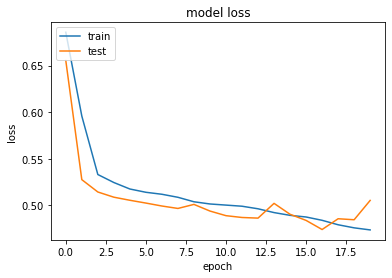

In [32]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
from keras.models import load_model
from sklearn import metrics
model = load_model('best_model.h5')

y_pred_one_hot = model.predict(X_testRusReshaped)
y_pred_labels = np.argmax(y_pred_one_hot, axis = 1)

y_true_labels = np.argmax(Y_testRusHot,axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

[[3347  974]
 [ 858 3463]]


In cases such as this, having a lower false negative is better than having a lower false positive. This is because identifying a malignant tumour as benign is more dangerous than identifying a benign tumour as malignant, since the former will result in the patient receiving a different treatment due to misdiagnosis, and the latter is likely to go through further tests anyway.
We can see that our model performs well with an accuracy of 79% on the test set. The confusion matrix only is also favourable for us and we have a model with low variance.